In [1]:
import numpy as np
import itertools
import time
import matplotlib.pyplot as plt
import MDAnalysis as mda
import pickle
#from numba import jit
#from numba import njit

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
np.__version__

'1.21.6'

In [4]:
mda.__version__

'2.1.0'

In [6]:
def trapezoid(y, dx=1):
    
    tmp = 0
    
    for i in range(0,len(y)-1):
        
        tmp += (y[i+1]+y[i])/2
        
    return tmp*dx

In [7]:
def convert_spherical(xyz):
    
    # converting xyz coordinates to the spherical coordinates 
    
    r = np.sqrt(xyz[0]**2 + xyz[1]**2 + xyz[2]**2) # magnitude
    
    r_tmp = np.sqrt(xyz[0]**2 + xyz[1]**2)
    
    theta = np.arctan2(r_tmp, xyz[2])
    phi = np.arctan2(xyz[1], xyz[0]) # arctan2 considers the sign of x,y while computing the angle
    
    tmp = np.zeros((3))
    tmp[0] = r
    tmp[1] = theta
    tmp[2] = phi
    
    return tmp

In [8]:
#@njit
def f1re(rtp):
    
    """ 
    Real part of the F1
    """
    
    return np.sin(rtp[:,1]) * np.cos(rtp[:,1]) * np.cos(rtp[:,2]) / (rtp[:,0]**3)

In [9]:
#@njit
def f1im(rtp):
    
    """ 
    Imaginary part of the F1
    """
    
    return -np.sin(rtp[:,1]) * np.cos(rtp[:,1]) * np.sin(rtp[:,2]) / (rtp[:,0]**3)

In [10]:
#@njit
def f2re(rtp):
    
    """ 
    Real part of the F2
    """
    
    return np.sin(rtp[:,1])**2 * ( np.cos(rtp[:,2])**2 - np.sin(rtp[:,2])**2 )/(rtp[:,0]**3)

In [11]:
#@njit
def f2im(rtp):
    
    """ 
    Imaginary part of the F2
    """
    
    return -2 * (np.sin(rtp[:,1])**2) * np.cos(rtp[:,2]) * np.sin(rtp[:,2]) / (rtp[:,0]**3)

In [12]:
def calc_tau(nframes, coor1, coor2):

    # this is the correlation function
    
    nframes_half = int(np.floor(nframes/2))
    corr = np.zeros((nframes))
    
    for tau in range(0, nframes_half):
        
        res = coor1[0:nframes-tau]*coor2[tau:nframes]

        corr[tau] = np.mean(res) # average 
        
    return corr

In [13]:
def calculate_t1(displacement):
            
    nframes = displacement.shape[0]
    
    # Calculating <F1(t)F*1(t+tau)>
    
    corr1 = calc_tau(nframes, f1re(displacement),f1re(displacement)) # Eq. 4
    corr2 = calc_tau(nframes, f1im(displacement),f1im(displacement)) # Eq. 4
    
    # Calculating <F2(t)F*2(t+tau)>
    
    corr2_1 = calc_tau(nframes, f2re(displacement),f2re(displacement)) # Eq. 4
    corr2_2 = calc_tau(nframes, f2im(displacement), f2im(displacement)) # Eq. 4
    
        
    return np.array([corr1, corr2, corr2_1, corr2_2])

### TIP4P/2005 ###

In [14]:
u = mda.Universe('./tip4p_2005/run_all_bonds.tpr', './tip4p_2005/run_all_bonds.xtc')

In [15]:
# we should get T1 = 3.9 s #

In [16]:
#https://physics.nist.gov/cgi-bin/cuu/Value?gammapp

gamma = 2.675153151*10**8 #  s-1 T-1 
hbar = 1.0545718*10**(-34) # m^2 kg / s

dt = 1*10**(-12) # 1 ps saving frequency
factorT1 = 100; factorT2 = 10;
factor = 9/8*gamma**4*hbar**2
#(mu/(4*np.pi))**2*2

In [17]:
u.trajectory.units

{'time': 'ps', 'length': 'nm'}

In [18]:
u.trajectory

<XTCReader ./tip4p_2005/run_all_bonds.xtc with 100001 frames of 1440 atoms>

In [19]:
## let's get the intramolecular only (same water) ##
def intramolecular(u, init_frame, nframes=50):

    c1_intra = 0;
    c2_intra = 0;
    c3_intra = 0;
    c4_intra = 0;

    nres = len(u.select_atoms('name HW2').residues)

    for resid in u.residues:
    
        #print(resid, end ='\r')
    
        displacement = np.zeros((nframes,3))
        counter = 0
    
        h1 = resid.atoms[1]
        h2 = resid.atoms[2]
    
    #print('... calculating for ' + h1.name + '-' + h2.name)
    
        for ts in u.trajectory[init_frame:init_frame+nframes]:
            
            #print(ts, "", end='\r')
            
            disp = mda.lib.distances.minimize_vectors(h1.position - h2.position, u.dimensions)
        
            displacement[counter,:] = convert_spherical( disp ) # units in A
            counter += 1
    
        [c1_tmp, c2_tmp, c3_tmp, c4_tmp] = calculate_t1(displacement)/nres
    
    
    
        c1_intra += c1_tmp;
        c2_intra += c2_tmp;
        c3_intra += c3_tmp;
        c4_intra += c4_tmp;
        
    return np.array([c1_intra, c2_intra, c3_intra, c4_intra])
    

In [20]:
## let's get the intermolecular only (same water) ##
def intermolecular(u, init_frame, nframes=50):

    c1_inter = 0;
    c2_inter = 0;
    c3_inter = 0;
    c4_inter = 0;

    nres = len(u.select_atoms('name HW2').residues)
    
    # this is just for monitoring purposes #
    total_num_iterations = len(list(itertools.combinations(range(int(nres)),2)))
    loop_counter = 0

    for i in itertools.combinations(range(int(nres)),2):
    
    #print(resid)
        #print(loop_counter, '/', total_num_iterations, "", end = "\r")
    
        displacement = np.zeros((nframes,3))
        counter = 0
    
        h1 = u.residues[i[0]].atoms[1]
        h2 = u.residues[i[0]].atoms[2]
    
    #print('... calculating for ' + h1.name + '-' + h2.name)
    
        for ts in u.trajectory[init_frame:init_frame+nframes]:
            
            #print(ts, "", end='\r')
        
            disp = mda.lib.distances.minimize_vectors(h1.position - h2.position, u.dimensions)
        
            displacement[counter,:] = convert_spherical( disp ) # units in A
            
            counter += 1
    
        [c1_tmp, c2_tmp, c3_tmp, c4_tmp] = calculate_t1(displacement)/total_num_iterations
    
        c1_inter += c1_tmp;
        c2_inter += c2_tmp;
        c3_inter += c3_tmp;
        c4_inter += c4_tmp;
    
        loop_counter += 1
        
    return np.array([c1_inter, c2_inter, c3_inter, c4_inter])
    

In [21]:
# script to  run the T1 times for a range of starting frames #

u = mda.Universe('./tip4p_2005/run_all_bonds.tpr', './tip4p_2005/run_all_bonds.xtc')
init_frames = [1,10000,20000,30000,40000,50000]
results_intra = {}
results_inter = {}

for i in init_frames:
    
    print(i)
    results_intra[i] = intramolecular(u,i,50)
    results_inter[i] = intermolecular(u,i,50)
    print(1/(factor*trapezoid(np.sum(results_intra[i], axis=0) + 
                              np.sum(results_inter[i],axis=0), dx = 10**(-12)))*10**(-45))
    
with open('tip4p_2005_all_bonds_intra.pkl', 'wb') as f:
    pickle.dump(results_intra, f)
with open('tip4p_2005_all_bonds_inter.pkl', 'wb') as f:
    pickle.dump(results_inter, f)    

1
54.25612680288558
10000


KeyboardInterrupt: 

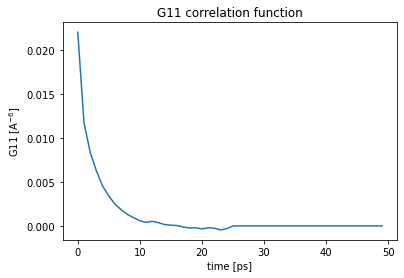

In [33]:
plt.plot(results_intra[1][0] + results_intra[1][1] + results_inter[1][0] + results_inter[1][0])
plt.title('G11 correlation function');
plt.ylabel(r'G11 [A$^{-6}$]');
plt.xlabel('time [ps]');

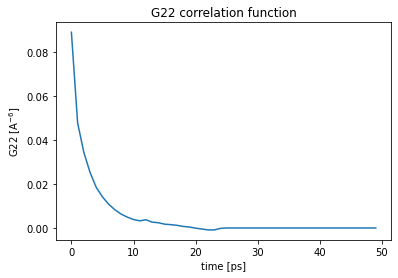

In [34]:
plt.plot(results_intra[1][2] + results_intra[1][3] + results_inter[1][2] + results_inter[1][3])
plt.title('G22 correlation function');
plt.ylabel(r'G22 [A$^{-6}$]');
plt.xlabel('time [ps]');